In [1]:

import subprocess
from sklearn.metrics.pairwise import euclidean_distances
from bioimage_phenotyping import Cellprofiler
import bioimage_phenotyping.dataset as dataset

# from bioimage_phenotyping.features import features
import bioimage_phenotyping.shapes as shapes
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from sklearn.preprocessing import FunctionTransformer

subprocess.run("make get.data", shell=True)

wget -nc "https://zenodo.org/record/7267108/files/results_csv.zip"
unzip -n results_csv.zip
Archive:  results_csv.zip


File ‘results_csv.zip’ already there; not retrieving.



CompletedProcess(args='make get.data', returncode=0)

In [2]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pathlib
import scipy
import warnings
from tqdm import tqdm
import dask.dataframe as dd
from sklearn import preprocessing

from bioimage_phenotyping import shapes, utils, features

# import shap
from sklearn.ensemble import RandomForestClassifier

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer

# from sklearn.base import BaseEstimator
# from sklearn.base import TransformerMixin


# from bioimage_phenotyping import utils

warnings.filterwarnings("ignore")
sns.set()
from bioimage_phenotyping import Cellprofiler

plt.ion()

VARIABLES = ["Conc /uM", "Date", "Drug"]
SAVE_FIG = True
SAVE_CSV = True
TEST_ROT = False

# kwargs_splinedist = {
#     "data_folder": "old_results/control_points",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }


# kwargs_cellprofiler = {
#     "data_folder": "results/analysed/cellprofiler/splinedist",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }

# kwargs_cellprofiler = {
#     "data_folder": "old_results/analysed/cellprofiler/splinedist",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }

# kwargs_splinedist = {
#     "data_folder": "results/splinedist",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }


# kwargs_cellprofiler = {
#     "data_folder": "unet/splinedist",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }

kwargs_splinedist = {
    "data_folder": "old_results/control_points",
    "nuclei_path": "objects_FilteredNuclei.csv",
}


kwargs_cellprofiler = {
    "data_folder": "old_results/analysed/cellprofiler/splinedist",
    "nuclei_path": "objects_FilteredNuclei.csv",
}

In [3]:


def save_csv(df, path):
    df.to_csv(metadata(path))
    return df


results_folder = f"results"
pathlib.Path(results_folder).mkdir(parents=True, exist_ok=True)


def metadata(x):
    path = pathlib.Path(results_folder, x)
    print(path)
    return path

In [4]:


def normalise_nd(arr):
    tmp = np.array(arr).ravel()
    bot = tmp.min()
    tmp = arr - tmp.min()
    top = tmp.max()
    return (arr - bot) / top


df_splinedist = (
    Cellprofiler(**kwargs_splinedist)
    .get_data()
    .apply(shapes.align_coords_to_origin_np, axis=1, raw=True)
    .pipe(normalise_nd)
    # .bip.preprocess()
    # .bip.preprocess()
    .bip.clean()
    .assign(Features="Control Points")
    .set_index(["Features"], append=True)
    # .apply(shapes.align_coords_to_origin_np, axis=1, raw=True)
    .sample(frac=1)
)

df_distance_matrix = (
    (df_splinedist.pipe(shapes.df_to_distance_matrix))
    .rename(index={"Control Points": "Control Points Dist"}, level="Features")
    .bip.preprocess()
)

df_distogram = (
    df_splinedist.pipe(shapes.df_to_distogram)
    .rename(index={"Control Points": "Distogram"}, level="Features")
    .bip.preprocess()
)

In [5]:

df_cellprofiler = (
    Cellprofiler(**kwargs_cellprofiler)
    .get_data()
    .bip.preprocess()
    .bip.clean()
    .assign(Features="CellProfiler")
    .set_index(["Features"], append=True)
    # .sample(32,axis=1,random_state=42)
)
df_cellprofiler.columns = df_cellprofiler.columns.str.replace("AreaShape_", "")

df = pd.concat([df_cellprofiler, df_splinedist, df_distance_matrix, df_distogram])


print(
    f'Organoids: {df.bip.grouped_median("ObjectNumber").bip.simple_counts()}',
    f"Nuclei: {df.bip.simple_counts()}",
)

Organoids: 515 Nuclei: 37235


In [6]:

pca_objs_df = df.groupby("Features").apply(features.pca.fit_na)
pca_df = df.groupby("Features").apply(features.pca.fit_transform_na)

explained_variance_df = df.groupby("Features").apply(features.pca.explained_variance)

pca_components_df = df.groupby("Features").apply(features.pca.components)

component_melt = pd.melt(
    pca_components_df,
    var_name="Feature",
    value_name="Component Magnitude",
    ignore_index=False,
).set_index(["Feature"], append=True)


important_features = (
    component_melt.transform(abs)
    .reset_index()
    .sort_values("Component Magnitude", ascending=False)
    .drop_duplicates(["Features", "Principal Component"])
    .sort_values("Principal Component")
)

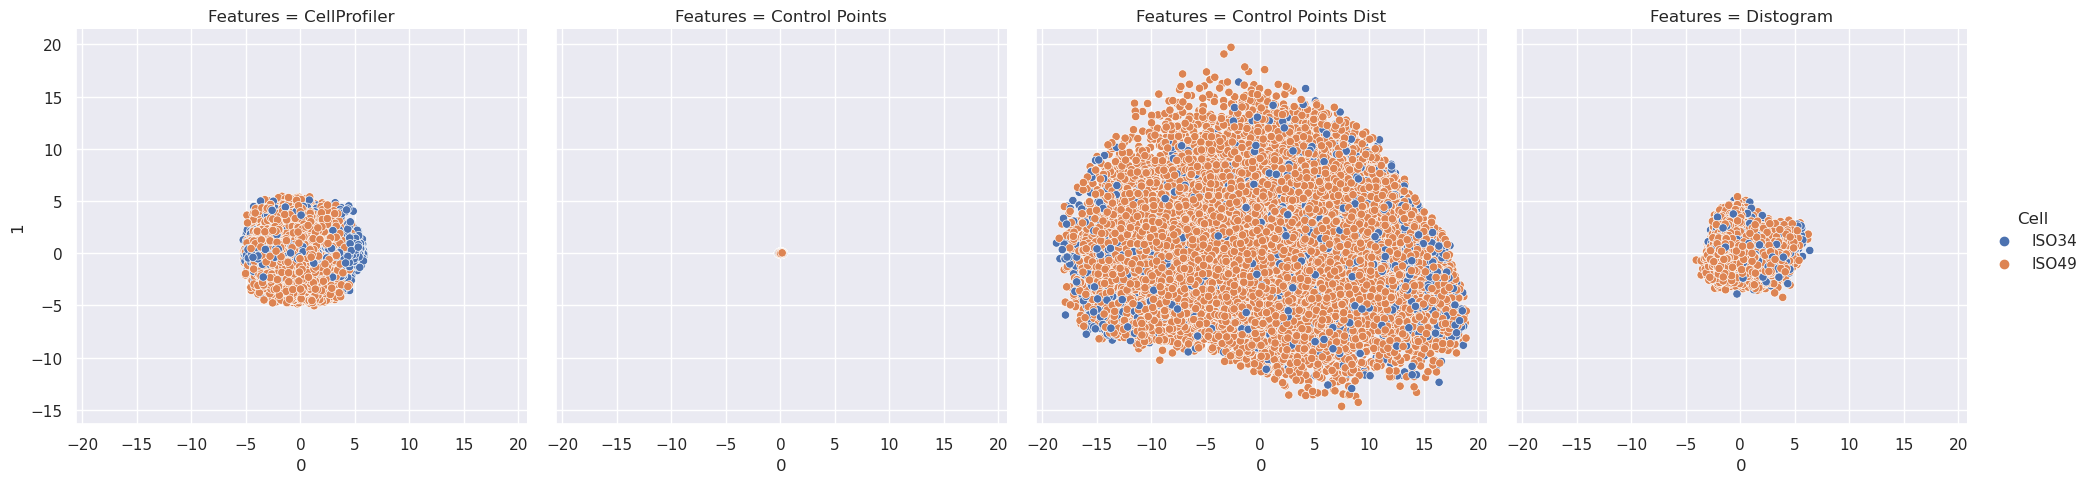

results/pca.csv
results/pca.pdf


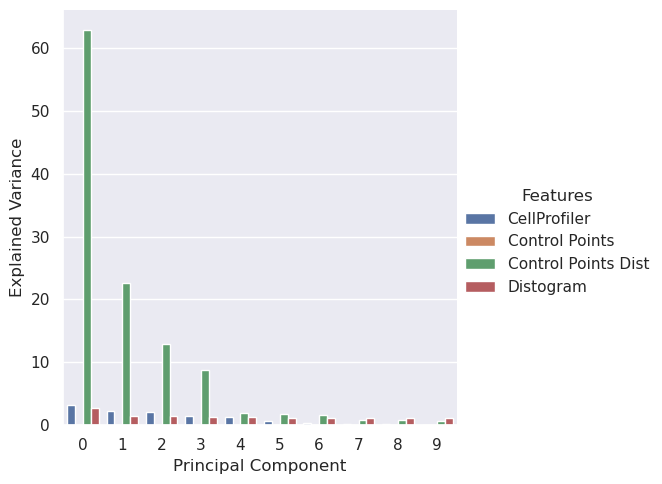

results/pca_components.csv


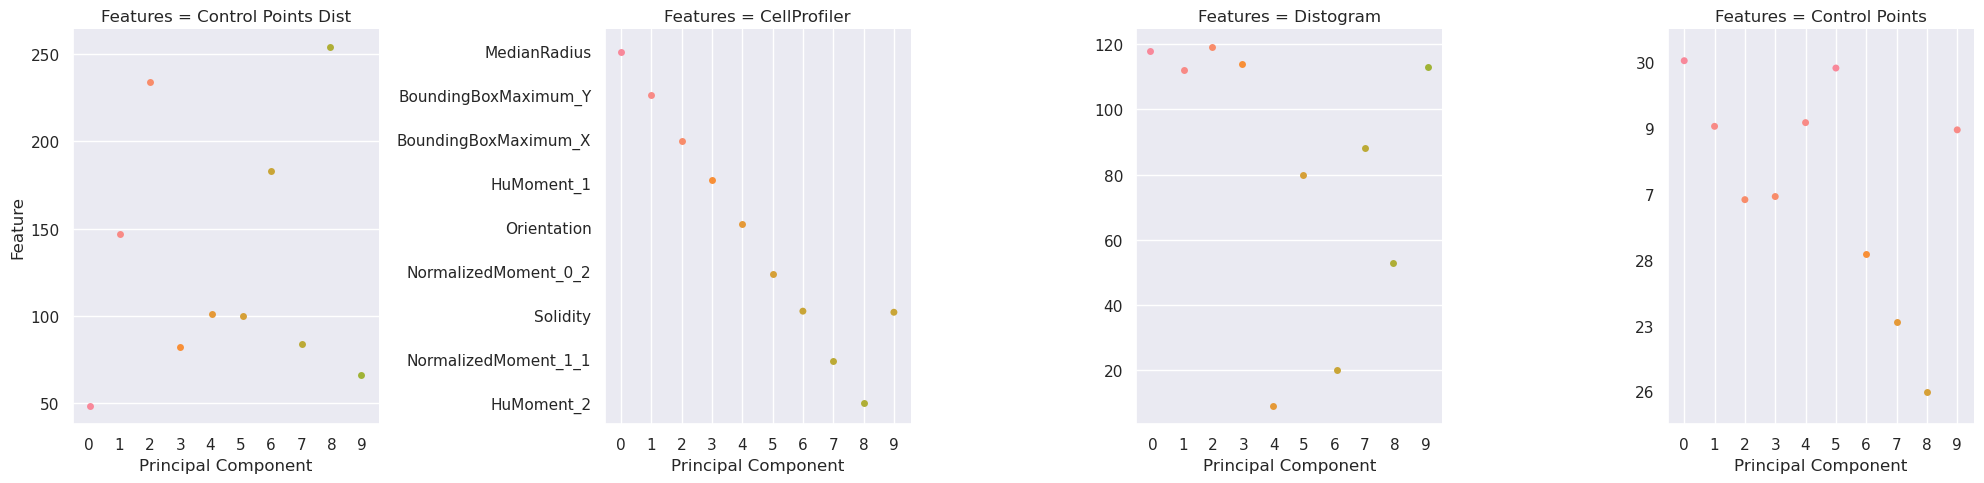

In [7]:
sns.relplot(data=pca_df, x=0, y=1, col="Features", hue="Cell")
plt.show()
plt.close()

# plt.figure()
sns.catplot(
    x="Principal Component",
    hue="Features",
    y="Explained Variance",
    data=explained_variance_df.reset_index().pipe(save_csv, "pca.csv"),
    legend_out=True,
    kind="bar",
)
plt.savefig(metadata("pca.pdf"), bbox_inches="tight")
plt.show()
plt.close()


# sns.catplot(
#     col="Principal Component",
#     y="Feature",
#     x="Component Magnitude",
#     sharey=False,
#     data=component_melt.reset_index(),
#     row="Features",
#     height=12,
# )
# plt.show()


sns.catplot(
    x="Principal Component",
    y="Feature",
    data=important_features.reset_index().pipe(save_csv, "pca_components.csv"),
    col="Features",
    sharey=False,
)
plt.show()
plt.close()


# df = df.iloc[:,random.sample(range(0, features), 32)]

results/fingerprints.pdf


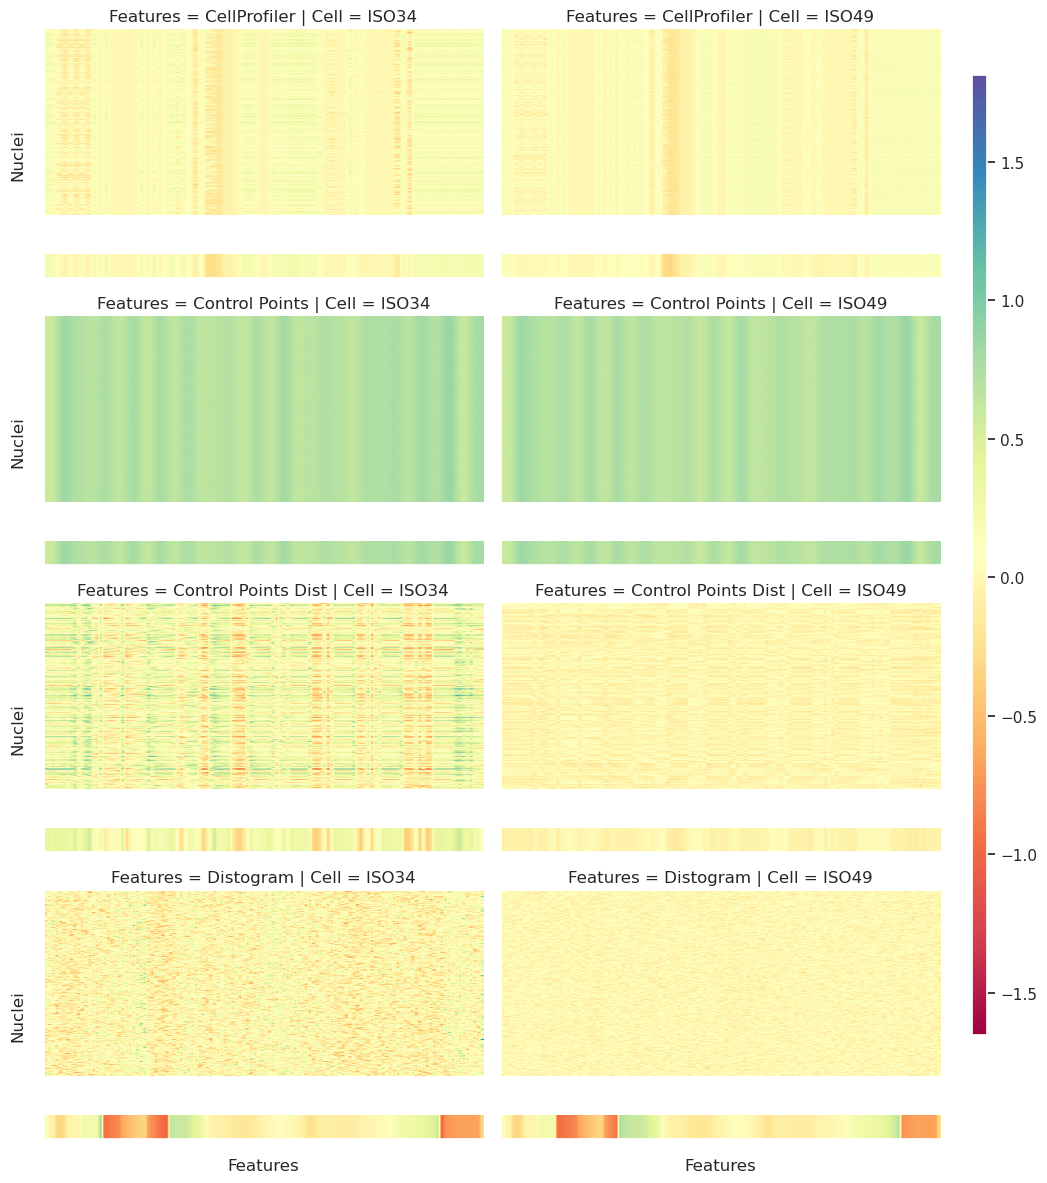

In [8]:


upper = np.nanmean(df.values.flatten()) + 2 * np.nanstd(df.values.flatten())
lower = np.nanmean(df.values.flatten()) - 2 * np.nanstd(df.values.flatten())


sns.set()
g = sns.FacetGrid(
    df.reset_index(level=["Cell", "Features"]),
    row="Features",
    col="Cell",
    # height=2,
    aspect=1.61,
    sharey=False,
    sharex=False,
    height=3,
    # col_wrap=2,
)
cax = g.fig.add_axes([1.015, 0.13, 0.015, 0.8])
g.map_dataframe(
    features.plotting.df_to_fingerprints_facet,
    "Features",
    "Nuclei",
    "Features",
    "Cell",
    cmap="Spectral",
    cbar=True,
    vmax=upper,
    vmin=lower,
)
plt.tight_layout()
plt.colorbar(cax=cax)
plt.savefig(metadata("fingerprints.pdf"), bbox_inches="tight")
plt.show()
plt.close()

In [9]:
augmentation = 0


def feature_importances(df, augment=None):
    return df.dropna(axis=1).bip.feature_importances(
        variable="Cell", kfolds=1, augment=augment
    )


def scoring(df, augment=None, kfolds=5):
    return df.dropna(axis=1).bip.get_scoring_df(
        variable="Cell", kfolds=kfolds, augment=augment
    )


spline_augment = lambda X, y: shapes.angular_augment_X_y(
    X, y, shapes.rotate_control_points_np, fold=augmentation
)

scoring_df = (
    df.groupby("Features")
    .apply(lambda df: df.bip.grouped_median("ObjectNumber").pipe(scoring))
    .reset_index("Features")
)

# scoring_df = df.groupby("Features").apply(
#     lambda df: df.pipe(scoring)
# ).reset_index("Features")

importance_df = (
    df.groupby("Features")
    .apply(lambda df: df.bip.grouped_median("ObjectNumber").pipe(feature_importances))
    .reset_index("Features")
)

# importance_df = df.groupby("Features").apply(
#     lambda df: df.pipe(feature_importances)
# ).reset_index("Features")


scoring_df_mean = scoring_df.groupby(["Metric", "Kind", "Variable", "Features"]).mean()
scoring_df_var = scoring_df.groupby(["Metric", "Kind", "Variable"]).var()

              precision    recall  f1-score   support

       ISO34       0.84      0.68      0.75        47
       ISO49       0.84      0.93      0.88        82

    accuracy                           0.84       129
   macro avg       0.84      0.80      0.82       129
weighted avg       0.84      0.84      0.83       129

0.6335722981198431


              precision    recall  f1-score   support

       ISO34       0.80      0.62      0.70        45
       ISO49       0.82      0.92      0.86        83

    accuracy                           0.81       128
   macro avg       0.81      0.77      0.78       128
weighted avg       0.81      0.81      0.81       128

0.5667136812411848


              precision    recall  f1-score   support

       ISO34       0.90      0.78      0.83        45
       ISO49       0.89      0.95      0.92        83

    accuracy                           0.89       128
   macro avg       0.89      0.86      0.88       128
weighted avg       0.89      0.89      0.89       128

0.7525545429439382
              precision    recall  f1-score   support

       ISO34       0.85      0.73      0.79        45
       ISO49       0.87      0.93      0.90        83

    accuracy                           0.86       128
   macro avg       0.86      0.83      0.84       128
weighted avg       0.86      0.86      0.86       128

0.6818558409279205


results/scoring.csv


results/scoring.pdf


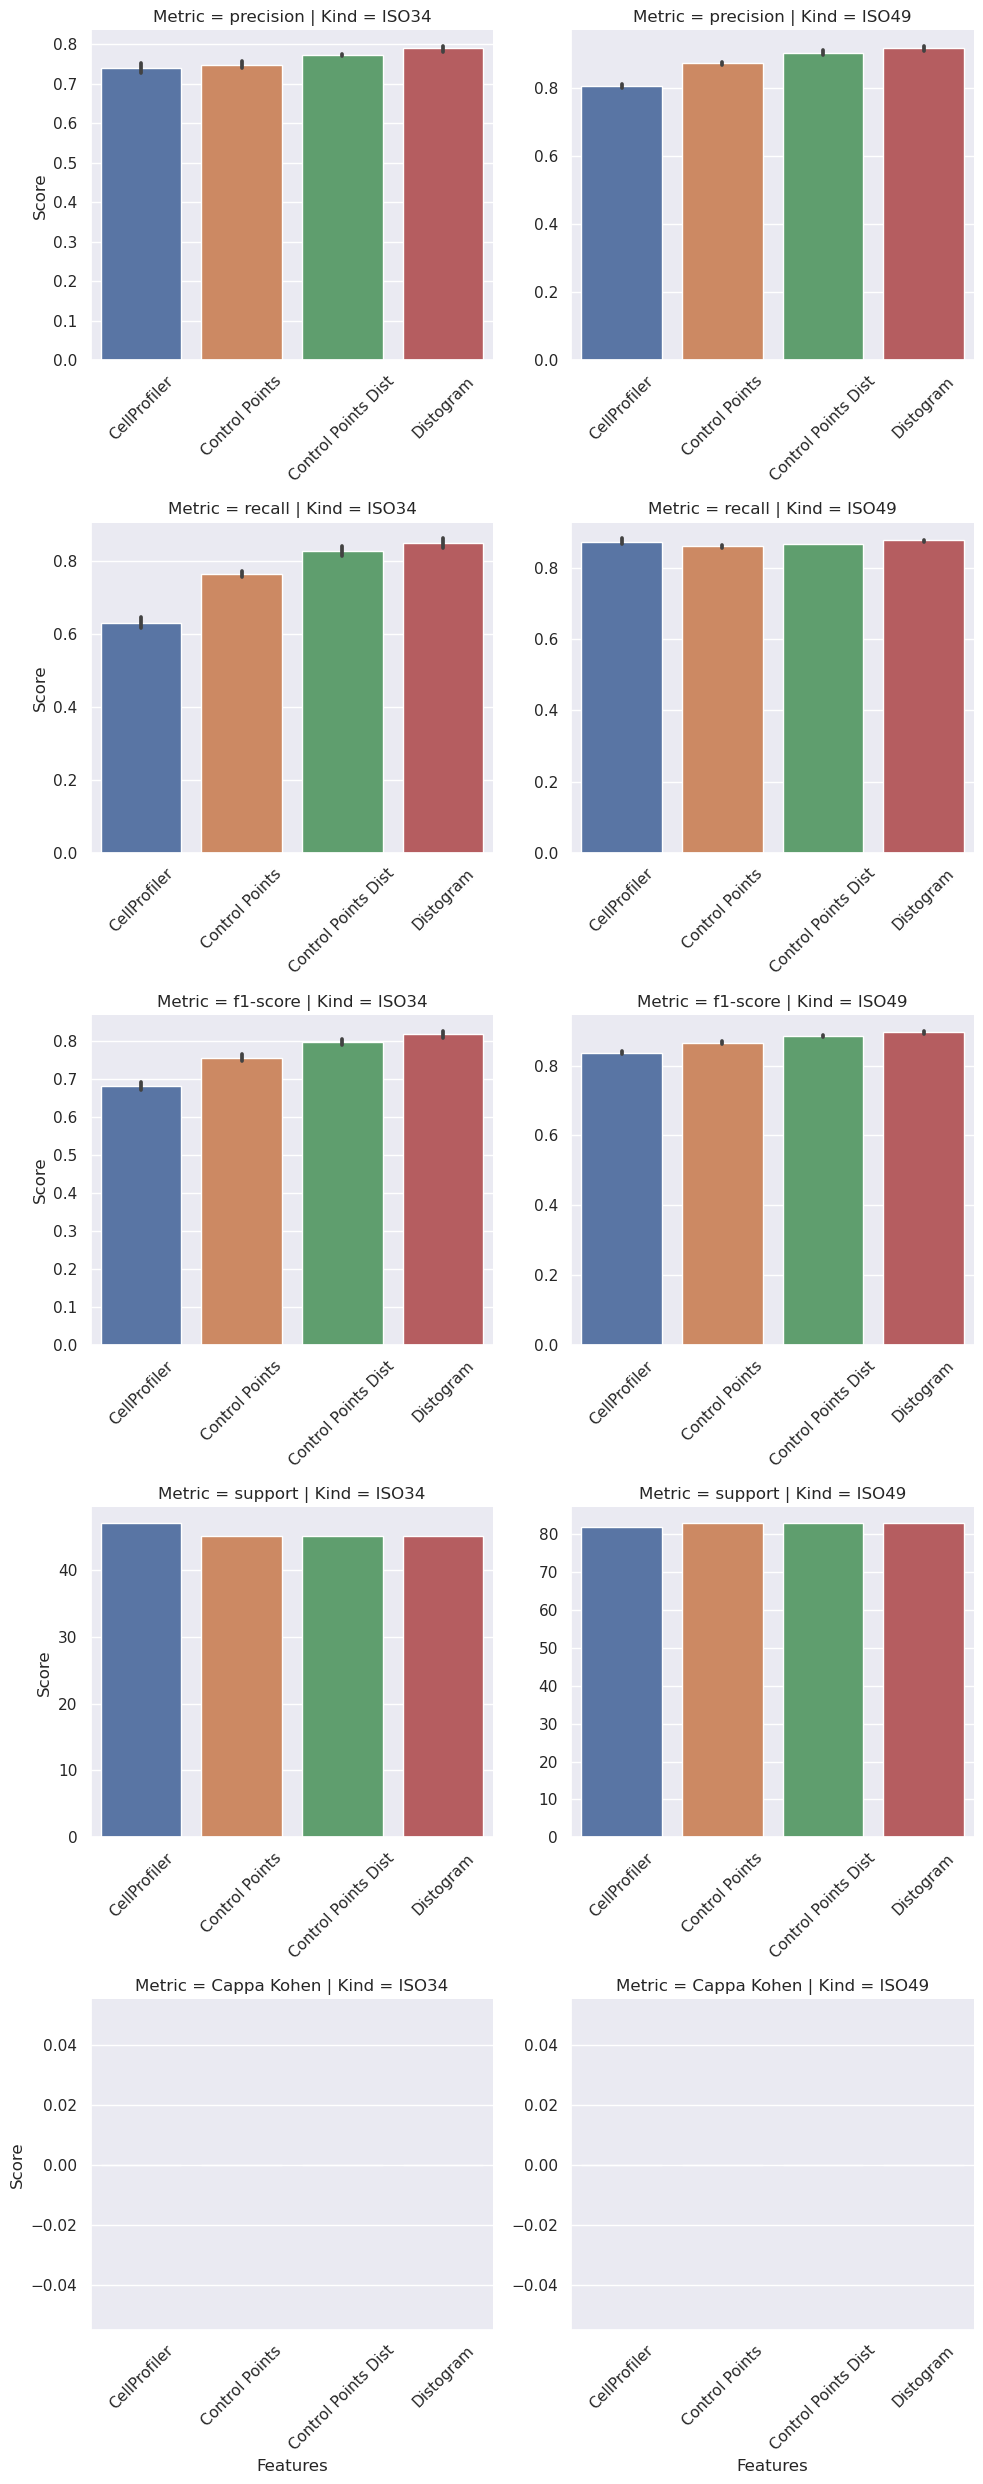

In [10]:
# data = scoring_df.reset_index("Features")
# data.to_csv("scoring_df.csv")
# sns.lmplot(
#     x="Augmentation",
#     y="Score",
#     col="Kind",
#     row="Metric",
#     hue="Features",
#     fit_reg=False,
#     sharey=False,
#     sharex=False,
#     x_ci="ci",
#     x_bins=5,
#     data=(scoring_df.reset_index("Features")),
# )

g = sns.catplot(
    # x="Augmentation",
    y="Score",
    col="Kind",
    row="Metric",
    x="Features",
    # fit_reg=False,
    sharey=False,
    sharex=False,
    # x_ci="ci",
    # x_bins=5,
    data=scoring_df.pipe(save_csv, "scoring.csv"),
    kind="bar",
)
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.savefig(metadata("scoring.pdf"))
plt.show()
plt.close()

results/feature_importance.csv


results/feature_importance.pdf


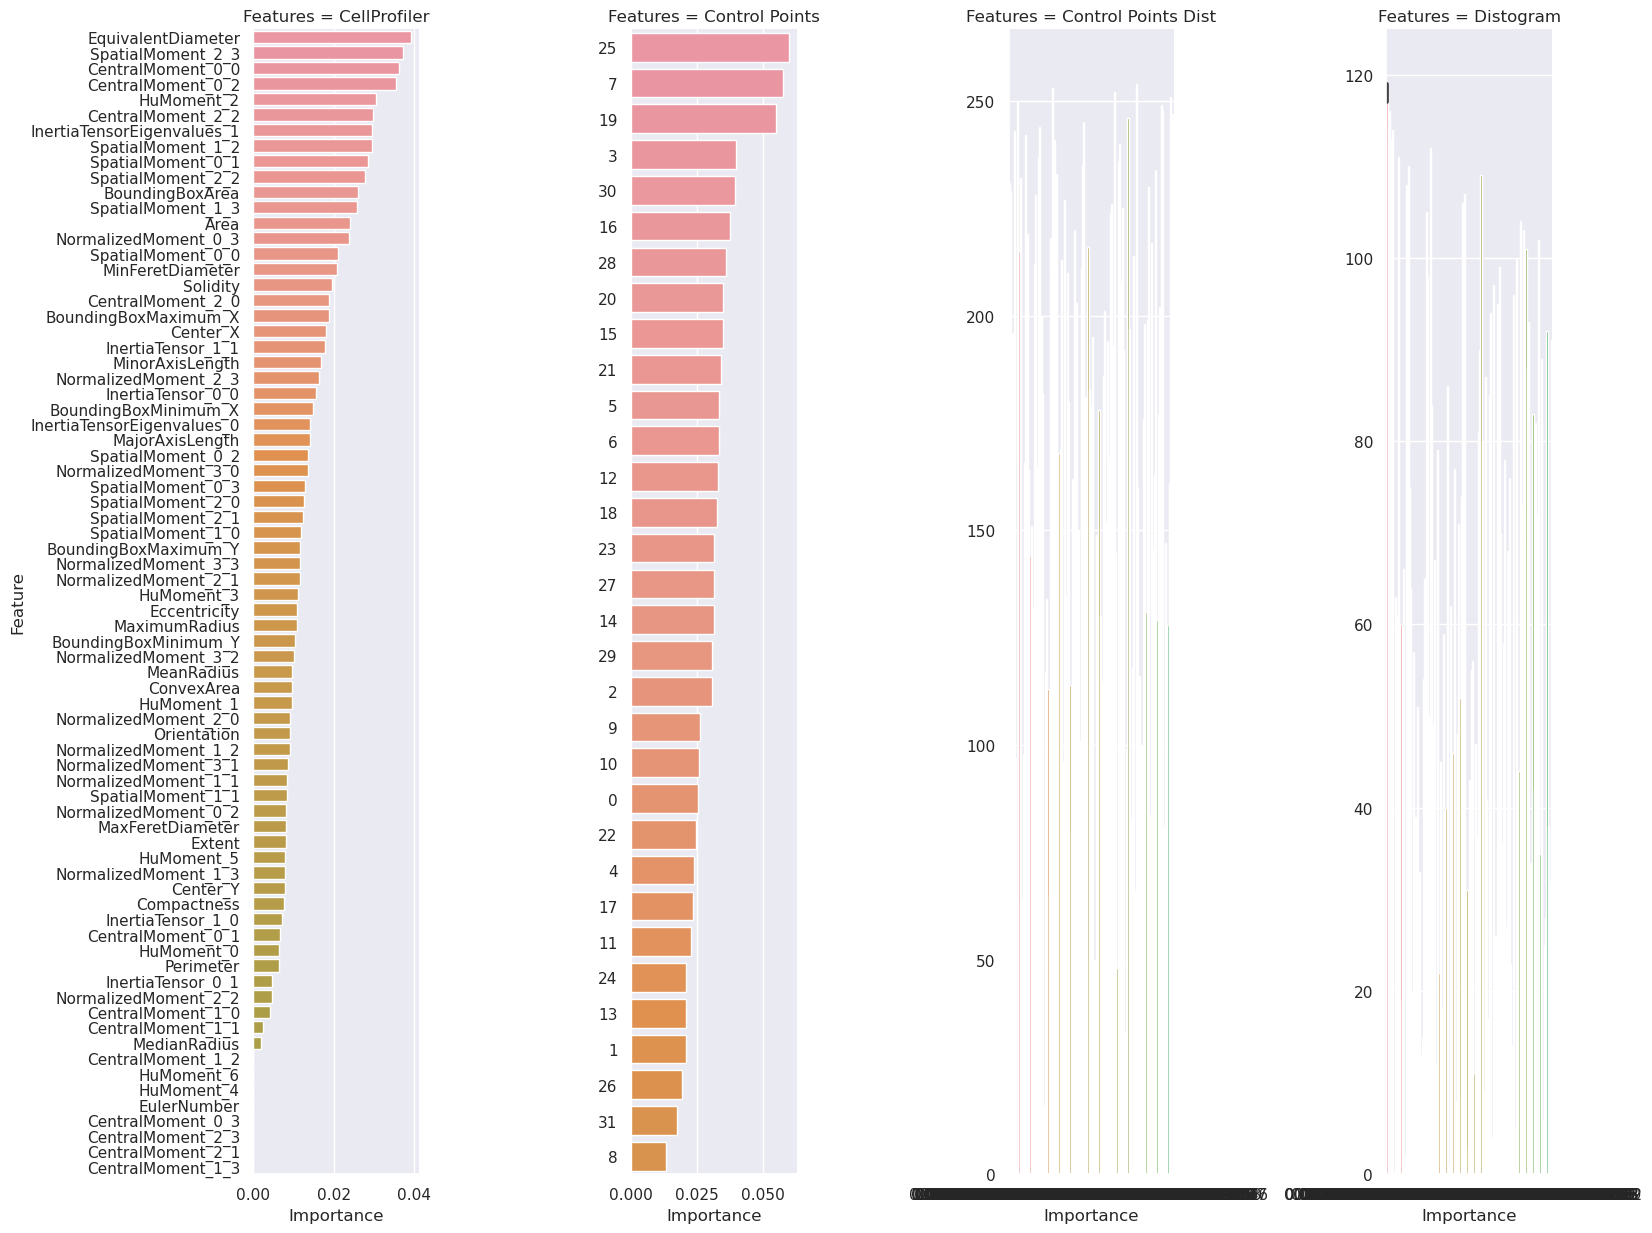

In [11]:
sns.catplot(
    y="Feature",
    x="Importance",
    col="Features",
    sharey=False,
    sharex=False,
    kind="bar",
    aspect=1 / 3,
    height=12.5,
    data=(importance_df.reset_index().pipe(save_csv, "feature_importance.csv")),
)
plt.savefig(metadata("feature_importance.pdf"))
plt.show()
plt.close()

Permutation explainer:  19%|█████████████████████▎                                                                                           | 97/515 [00:00<?, ?it/s]

Permutation explainer:  19%|████████████████████▏                                                                                   | 100/515 [00:10<00:24, 17.17it/s]

Permutation explainer:  20%|████████████████████▌                                                                                   | 102/515 [00:10<00:30, 13.47it/s]

Permutation explainer:  20%|█████████████████████                                                                                   | 104/515 [00:10<00:33, 12.43it/s]

Permutation explainer:  21%|█████████████████████▍                                                                                  | 106/515 [00:10<00:34, 11.82it/s]

Permutation explainer:  21%|█████████████████████▊                                                                                  | 108/515 [00:10<00:35, 11.47it/s]

Permutation explainer:  21%|██████████████████████▏                                                                                 | 110/515 [00:11<00:35, 11.27it/s]

Permutation explainer:  22%|██████████████████████▌                                                                                 | 112/515 [00:11<00:35, 11.23it/s]

Permutation explainer:  22%|███████████████████████                                                                                 | 114/515 [00:11<00:36, 11.11it/s]

Permutation explainer:  23%|███████████████████████▍                                                                                | 116/515 [00:11<00:35, 11.17it/s]

Permutation explainer:  23%|███████████████████████▊                                                                                | 118/515 [00:11<00:35, 11.22it/s]

Permutation explainer:  23%|████████████████████████▏                                                                               | 120/515 [00:12<00:35, 11.21it/s]

Permutation explainer:  24%|████████████████████████▋                                                                               | 122/515 [00:12<00:35, 11.12it/s]

Permutation explainer:  24%|█████████████████████████                                                                               | 124/515 [00:12<00:35, 11.04it/s]

Permutation explainer:  24%|█████████████████████████▍                                                                              | 126/515 [00:12<00:35, 11.11it/s]

Permutation explainer:  25%|█████████████████████████▊                                                                              | 128/515 [00:12<00:35, 11.04it/s]

Permutation explainer:  25%|██████████████████████████▎                                                                             | 130/515 [00:12<00:36, 10.58it/s]

Permutation explainer:  26%|██████████████████████████▋                                                                             | 132/515 [00:13<00:35, 10.80it/s]

Permutation explainer:  26%|███████████████████████████                                                                             | 134/515 [00:13<00:34, 11.13it/s]

Permutation explainer:  26%|███████████████████████████▍                                                                            | 136/515 [00:13<00:33, 11.15it/s]

Permutation explainer:  27%|███████████████████████████▊                                                                            | 138/515 [00:13<00:33, 11.16it/s]

Permutation explainer:  27%|████████████████████████████▎                                                                           | 140/515 [00:13<00:34, 10.92it/s]

Permutation explainer:  28%|████████████████████████████▋                                                                           | 142/515 [00:14<00:34, 10.76it/s]

Permutation explainer:  28%|█████████████████████████████                                                                           | 144/515 [00:14<00:33, 10.97it/s]

Permutation explainer:  28%|█████████████████████████████▍                                                                          | 146/515 [00:14<00:32, 11.20it/s]

Permutation explainer:  29%|█████████████████████████████▉                                                                          | 148/515 [00:14<00:32, 11.15it/s]

Permutation explainer:  29%|██████████████████████████████▎                                                                         | 150/515 [00:14<00:32, 11.12it/s]

Permutation explainer:  30%|██████████████████████████████▋                                                                         | 152/515 [00:14<00:33, 10.92it/s]

Permutation explainer:  30%|███████████████████████████████                                                                         | 154/515 [00:15<00:33, 10.93it/s]

Permutation explainer:  30%|███████████████████████████████▌                                                                        | 156/515 [00:15<00:32, 11.04it/s]

Permutation explainer:  31%|███████████████████████████████▉                                                                        | 158/515 [00:15<00:32, 11.03it/s]

Permutation explainer:  31%|████████████████████████████████▎                                                                       | 160/515 [00:15<00:32, 10.84it/s]

Permutation explainer:  31%|████████████████████████████████▋                                                                       | 162/515 [00:15<00:32, 10.93it/s]

Permutation explainer:  32%|█████████████████████████████████                                                                       | 164/515 [00:16<00:31, 11.12it/s]

Permutation explainer:  32%|█████████████████████████████████▌                                                                      | 166/515 [00:16<00:31, 11.05it/s]

Permutation explainer:  33%|█████████████████████████████████▉                                                                      | 168/515 [00:16<00:31, 11.01it/s]

Permutation explainer:  33%|██████████████████████████████████▎                                                                     | 170/515 [00:16<00:31, 10.98it/s]

Permutation explainer:  33%|██████████████████████████████████▋                                                                     | 172/515 [00:16<00:36,  9.31it/s]

Permutation explainer:  34%|███████████████████████████████████▏                                                                    | 174/515 [00:17<00:34,  9.83it/s]

Permutation explainer:  34%|███████████████████████████████████▌                                                                    | 176/515 [00:17<00:33, 10.07it/s]

Permutation explainer:  35%|███████████████████████████████████▉                                                                    | 178/515 [00:17<00:32, 10.38it/s]

Permutation explainer:  35%|████████████████████████████████████▎                                                                   | 180/515 [00:17<00:31, 10.61it/s]

Permutation explainer:  35%|████████████████████████████████████▊                                                                   | 182/515 [00:17<00:31, 10.69it/s]

Permutation explainer:  36%|█████████████████████████████████████▏                                                                  | 184/515 [00:17<00:30, 10.73it/s]

Permutation explainer:  36%|█████████████████████████████████████▌                                                                  | 186/515 [00:18<00:30, 10.87it/s]

Permutation explainer:  37%|█████████████████████████████████████▉                                                                  | 188/515 [00:18<00:30, 10.88it/s]

Permutation explainer:  37%|██████████████████████████████████████▎                                                                 | 190/515 [00:18<00:29, 10.95it/s]

Permutation explainer:  37%|██████████████████████████████████████▊                                                                 | 192/515 [00:18<00:29, 10.89it/s]

Permutation explainer:  38%|███████████████████████████████████████▏                                                                | 194/515 [00:18<00:29, 10.72it/s]

Permutation explainer:  38%|███████████████████████████████████████▌                                                                | 196/515 [00:19<00:29, 10.78it/s]

Permutation explainer:  38%|███████████████████████████████████████▉                                                                | 198/515 [00:19<00:29, 10.91it/s]

Permutation explainer:  39%|████████████████████████████████████████▍                                                               | 200/515 [00:19<00:28, 10.98it/s]

Permutation explainer:  39%|████████████████████████████████████████▊                                                               | 202/515 [00:19<00:28, 11.06it/s]

Permutation explainer:  40%|█████████████████████████████████████████▏                                                              | 204/515 [00:19<00:27, 11.20it/s]

Permutation explainer:  40%|█████████████████████████████████████████▌                                                              | 206/515 [00:19<00:27, 11.09it/s]

Permutation explainer:  40%|██████████████████████████████████████████                                                              | 208/515 [00:20<00:27, 11.19it/s]

Permutation explainer:  41%|██████████████████████████████████████████▍                                                             | 210/515 [00:20<00:27, 11.20it/s]

Permutation explainer:  41%|██████████████████████████████████████████▊                                                             | 212/515 [00:20<00:27, 11.07it/s]

Permutation explainer:  42%|███████████████████████████████████████████▏                                                            | 214/515 [00:20<00:27, 11.04it/s]

Permutation explainer:  42%|███████████████████████████████████████████▌                                                            | 216/515 [00:20<00:27, 10.89it/s]

Permutation explainer:  42%|████████████████████████████████████████████                                                            | 218/515 [00:21<00:27, 10.86it/s]

Permutation explainer:  43%|████████████████████████████████████████████▍                                                           | 220/515 [00:21<00:27, 10.89it/s]

Permutation explainer:  43%|████████████████████████████████████████████▊                                                           | 222/515 [00:21<00:26, 10.96it/s]

Permutation explainer:  43%|█████████████████████████████████████████████▏                                                          | 224/515 [00:21<00:26, 10.99it/s]

Permutation explainer:  44%|█████████████████████████████████████████████▋                                                          | 226/515 [00:21<00:26, 10.99it/s]

Permutation explainer:  44%|██████████████████████████████████████████████                                                          | 228/515 [00:21<00:26, 10.88it/s]

Permutation explainer:  45%|██████████████████████████████████████████████▍                                                         | 230/515 [00:22<00:25, 10.96it/s]

Permutation explainer:  45%|██████████████████████████████████████████████▊                                                         | 232/515 [00:22<00:25, 11.05it/s]

Permutation explainer:  45%|███████████████████████████████████████████████▎                                                        | 234/515 [00:22<00:25, 11.08it/s]

Permutation explainer:  46%|███████████████████████████████████████████████▋                                                        | 236/515 [00:22<00:25, 11.09it/s]

Permutation explainer:  46%|████████████████████████████████████████████████                                                        | 238/515 [00:22<00:25, 10.95it/s]

Permutation explainer:  47%|████████████████████████████████████████████████▍                                                       | 240/515 [00:23<00:25, 10.98it/s]

Permutation explainer:  47%|████████████████████████████████████████████████▊                                                       | 242/515 [00:23<00:24, 11.03it/s]

Permutation explainer:  47%|█████████████████████████████████████████████████▎                                                      | 244/515 [00:23<00:24, 11.08it/s]

Permutation explainer:  48%|█████████████████████████████████████████████████▋                                                      | 246/515 [00:23<00:24, 11.09it/s]

Permutation explainer:  48%|██████████████████████████████████████████████████                                                      | 248/515 [00:23<00:24, 11.08it/s]

Permutation explainer:  49%|██████████████████████████████████████████████████▍                                                     | 250/515 [00:23<00:24, 10.97it/s]

Permutation explainer:  49%|██████████████████████████████████████████████████▉                                                     | 252/515 [00:24<00:23, 11.01it/s]

Permutation explainer:  49%|███████████████████████████████████████████████████▎                                                    | 254/515 [00:24<00:23, 11.08it/s]

Permutation explainer:  50%|███████████████████████████████████████████████████▋                                                    | 256/515 [00:24<00:23, 11.08it/s]

Permutation explainer:  50%|████████████████████████████████████████████████████                                                    | 258/515 [00:24<00:23, 11.10it/s]

Permutation explainer:  50%|████████████████████████████████████████████████████▌                                                   | 260/515 [00:24<00:23, 11.04it/s]

Permutation explainer:  51%|████████████████████████████████████████████████████▉                                                   | 262/515 [00:25<00:23, 10.96it/s]

Permutation explainer:  51%|█████████████████████████████████████████████████████▎                                                  | 264/515 [00:25<00:22, 11.00it/s]

Permutation explainer:  52%|█████████████████████████████████████████████████████▋                                                  | 266/515 [00:25<00:22, 11.08it/s]

Permutation explainer:  52%|██████████████████████████████████████████████████████                                                  | 268/515 [00:25<00:22, 11.07it/s]

Permutation explainer:  52%|██████████████████████████████████████████████████████▌                                                 | 270/515 [00:25<00:25,  9.43it/s]

Permutation explainer:  53%|██████████████████████████████████████████████████████▉                                                 | 272/515 [00:26<00:24,  9.78it/s]

Permutation explainer:  53%|███████████████████████████████████████████████████████▎                                                | 274/515 [00:26<00:23, 10.21it/s]

Permutation explainer:  54%|███████████████████████████████████████████████████████▋                                                | 276/515 [00:26<00:22, 10.50it/s]

Permutation explainer:  54%|████████████████████████████████████████████████████████▏                                               | 278/515 [00:26<00:22, 10.68it/s]

Permutation explainer:  54%|████████████████████████████████████████████████████████▌                                               | 280/515 [00:26<00:21, 10.74it/s]

Permutation explainer:  55%|████████████████████████████████████████████████████████▉                                               | 282/515 [00:26<00:21, 10.74it/s]

Permutation explainer:  55%|█████████████████████████████████████████████████████████▎                                              | 284/515 [00:27<00:21, 10.91it/s]

Permutation explainer:  56%|█████████████████████████████████████████████████████████▊                                              | 286/515 [00:27<00:20, 11.00it/s]

Permutation explainer:  56%|██████████████████████████████████████████████████████████▏                                             | 288/515 [00:27<00:20, 11.03it/s]

Permutation explainer:  56%|██████████████████████████████████████████████████████████▌                                             | 290/515 [00:27<00:20, 11.08it/s]

Permutation explainer:  57%|██████████████████████████████████████████████████████████▉                                             | 292/515 [00:27<00:20, 11.03it/s]

Permutation explainer:  57%|███████████████████████████████████████████████████████████▎                                            | 294/515 [00:28<00:20, 10.98it/s]

Permutation explainer:  57%|███████████████████████████████████████████████████████████▊                                            | 296/515 [00:28<00:19, 11.03it/s]

Permutation explainer:  58%|████████████████████████████████████████████████████████████▏                                           | 298/515 [00:28<00:19, 11.07it/s]

Permutation explainer:  58%|████████████████████████████████████████████████████████████▌                                           | 300/515 [00:28<00:19, 11.15it/s]

Permutation explainer:  59%|████████████████████████████████████████████████████████████▉                                           | 302/515 [00:28<00:19, 11.12it/s]

Permutation explainer:  59%|█████████████████████████████████████████████████████████████▍                                          | 304/515 [00:28<00:19, 10.94it/s]

Permutation explainer:  59%|█████████████████████████████████████████████████████████████▊                                          | 306/515 [00:29<00:19, 11.00it/s]

Permutation explainer:  60%|██████████████████████████████████████████████████████████████▏                                         | 308/515 [00:29<00:18, 11.09it/s]

Permutation explainer:  60%|██████████████████████████████████████████████████████████████▌                                         | 310/515 [00:29<00:18, 11.13it/s]

Permutation explainer:  61%|███████████████████████████████████████████████████████████████                                         | 312/515 [00:29<00:18, 11.13it/s]

Permutation explainer:  61%|███████████████████████████████████████████████████████████████▍                                        | 314/515 [00:29<00:18, 10.85it/s]

Permutation explainer:  61%|███████████████████████████████████████████████████████████████▊                                        | 316/515 [00:30<00:18, 10.78it/s]

Permutation explainer:  62%|████████████████████████████████████████████████████████████████▏                                       | 318/515 [00:30<00:18, 10.88it/s]

Permutation explainer:  62%|████████████████████████████████████████████████████████████████▌                                       | 320/515 [00:30<00:17, 10.96it/s]

Permutation explainer:  63%|█████████████████████████████████████████████████████████████████                                       | 322/515 [00:30<00:17, 11.04it/s]

Permutation explainer:  63%|█████████████████████████████████████████████████████████████████▍                                      | 324/515 [00:30<00:17, 11.04it/s]

Permutation explainer:  63%|█████████████████████████████████████████████████████████████████▊                                      | 326/515 [00:30<00:17, 10.99it/s]

Permutation explainer:  64%|██████████████████████████████████████████████████████████████████▏                                     | 328/515 [00:31<00:16, 11.05it/s]

Permutation explainer:  64%|██████████████████████████████████████████████████████████████████▋                                     | 330/515 [00:31<00:16, 11.09it/s]

Permutation explainer:  64%|███████████████████████████████████████████████████████████████████                                     | 332/515 [00:31<00:16, 11.15it/s]

Permutation explainer:  65%|███████████████████████████████████████████████████████████████████▍                                    | 334/515 [00:31<00:16, 11.15it/s]

Permutation explainer:  65%|███████████████████████████████████████████████████████████████████▊                                    | 336/515 [00:31<00:16, 10.99it/s]

Permutation explainer:  66%|████████████████████████████████████████████████████████████████████▎                                   | 338/515 [00:32<00:16, 10.98it/s]

Permutation explainer:  66%|████████████████████████████████████████████████████████████████████▋                                   | 340/515 [00:32<00:15, 11.08it/s]

Permutation explainer:  66%|█████████████████████████████████████████████████████████████████████                                   | 342/515 [00:32<00:15, 11.16it/s]

Permutation explainer:  67%|█████████████████████████████████████████████████████████████████████▍                                  | 344/515 [00:32<00:15, 11.13it/s]

Permutation explainer:  67%|█████████████████████████████████████████████████████████████████████▊                                  | 346/515 [00:32<00:15, 11.12it/s]

Permutation explainer:  68%|██████████████████████████████████████████████████████████████████████▎                                 | 348/515 [00:32<00:15, 10.91it/s]

Permutation explainer:  68%|██████████████████████████████████████████████████████████████████████▋                                 | 350/515 [00:33<00:15, 10.99it/s]

Permutation explainer:  68%|███████████████████████████████████████████████████████████████████████                                 | 352/515 [00:33<00:14, 11.02it/s]

Permutation explainer:  69%|███████████████████████████████████████████████████████████████████████▍                                | 354/515 [00:33<00:14, 11.07it/s]

Permutation explainer:  69%|███████████████████████████████████████████████████████████████████████▉                                | 356/515 [00:33<00:14, 11.08it/s]

Permutation explainer:  70%|████████████████████████████████████████████████████████████████████████▎                               | 358/515 [00:33<00:14, 11.05it/s]

Permutation explainer:  70%|████████████████████████████████████████████████████████████████████████▋                               | 360/515 [00:34<00:14, 10.92it/s]

Permutation explainer:  70%|█████████████████████████████████████████████████████████████████████████                               | 362/515 [00:34<00:13, 10.99it/s]

Permutation explainer:  71%|█████████████████████████████████████████████████████████████████████████▌                              | 364/515 [00:34<00:13, 11.08it/s]

Permutation explainer:  71%|█████████████████████████████████████████████████████████████████████████▉                              | 366/515 [00:34<00:13, 11.12it/s]

Permutation explainer:  71%|██████████████████████████████████████████████████████████████████████████▎                             | 368/515 [00:34<00:15,  9.58it/s]

Permutation explainer:  72%|██████████████████████████████████████████████████████████████████████████▋                             | 370/515 [00:35<00:14,  9.95it/s]

Permutation explainer:  72%|███████████████████████████████████████████████████████████████████████████                             | 372/515 [00:35<00:13, 10.30it/s]

Permutation explainer:  73%|███████████████████████████████████████████████████████████████████████████▌                            | 374/515 [00:35<00:13, 10.56it/s]

Permutation explainer:  73%|███████████████████████████████████████████████████████████████████████████▉                            | 376/515 [00:35<00:12, 10.74it/s]

Permutation explainer:  73%|████████████████████████████████████████████████████████████████████████████▎                           | 378/515 [00:35<00:12, 10.86it/s]

Permutation explainer:  74%|████████████████████████████████████████████████████████████████████████████▋                           | 380/515 [00:35<00:12, 10.79it/s]

Permutation explainer:  74%|█████████████████████████████████████████████████████████████████████████████▏                          | 382/515 [00:36<00:12, 10.79it/s]

Permutation explainer:  75%|█████████████████████████████████████████████████████████████████████████████▌                          | 384/515 [00:36<00:12, 10.90it/s]

Permutation explainer:  75%|█████████████████████████████████████████████████████████████████████████████▉                          | 386/515 [00:36<00:11, 10.99it/s]

Permutation explainer:  75%|██████████████████████████████████████████████████████████████████████████████▎                         | 388/515 [00:36<00:11, 11.06it/s]

Permutation explainer:  76%|██████████████████████████████████████████████████████████████████████████████▊                         | 390/515 [00:36<00:11, 10.98it/s]

Permutation explainer:  76%|███████████████████████████████████████████████████████████████████████████████▏                        | 392/515 [00:37<00:11, 11.12it/s]

Permutation explainer:  77%|███████████████████████████████████████████████████████████████████████████████▌                        | 394/515 [00:37<00:10, 11.15it/s]

Permutation explainer:  77%|███████████████████████████████████████████████████████████████████████████████▉                        | 396/515 [00:37<00:10, 11.19it/s]

Permutation explainer:  77%|████████████████████████████████████████████████████████████████████████████████▎                       | 398/515 [00:37<00:10, 11.17it/s]

Permutation explainer:  78%|████████████████████████████████████████████████████████████████████████████████▊                       | 400/515 [00:37<00:10, 11.17it/s]

Permutation explainer:  78%|█████████████████████████████████████████████████████████████████████████████████▏                      | 402/515 [00:37<00:10, 11.01it/s]

Permutation explainer:  78%|█████████████████████████████████████████████████████████████████████████████████▌                      | 404/515 [00:38<00:10, 10.98it/s]

Permutation explainer:  79%|█████████████████████████████████████████████████████████████████████████████████▉                      | 406/515 [00:38<00:09, 11.03it/s]

Permutation explainer:  79%|██████████████████████████████████████████████████████████████████████████████████▍                     | 408/515 [00:38<00:09, 11.07it/s]

Permutation explainer:  80%|██████████████████████████████████████████████████████████████████████████████████▊                     | 410/515 [00:38<00:09, 11.12it/s]

Permutation explainer:  80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 412/515 [00:38<00:09, 11.07it/s]

Permutation explainer:  80%|███████████████████████████████████████████████████████████████████████████████████▌                    | 414/515 [00:39<00:09, 10.97it/s]

Permutation explainer:  81%|████████████████████████████████████████████████████████████████████████████████████                    | 416/515 [00:39<00:08, 11.06it/s]

Permutation explainer:  81%|████████████████████████████████████████████████████████████████████████████████████▍                   | 418/515 [00:39<00:08, 11.10it/s]

Permutation explainer:  82%|████████████████████████████████████████████████████████████████████████████████████▊                   | 420/515 [00:39<00:08, 11.16it/s]

Permutation explainer:  82%|█████████████████████████████████████████████████████████████████████████████████████▏                  | 422/515 [00:39<00:08, 11.18it/s]

Permutation explainer:  82%|█████████████████████████████████████████████████████████████████████████████████████▌                  | 424/515 [00:39<00:08, 10.98it/s]

Permutation explainer:  83%|██████████████████████████████████████████████████████████████████████████████████████                  | 426/515 [00:40<00:08, 11.06it/s]

Permutation explainer:  83%|██████████████████████████████████████████████████████████████████████████████████████▍                 | 428/515 [00:40<00:07, 11.12it/s]

Permutation explainer:  83%|██████████████████████████████████████████████████████████████████████████████████████▊                 | 430/515 [00:40<00:07, 11.16it/s]

Permutation explainer:  84%|███████████████████████████████████████████████████████████████████████████████████████▏                | 432/515 [00:40<00:07, 11.16it/s]

Permutation explainer:  84%|███████████████████████████████████████████████████████████████████████████████████████▋                | 434/515 [00:40<00:07, 11.23it/s]

Permutation explainer:  85%|████████████████████████████████████████████████████████████████████████████████████████                | 436/515 [00:40<00:07, 11.09it/s]

Permutation explainer:  85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 438/515 [00:41<00:06, 11.12it/s]

Permutation explainer:  85%|████████████████████████████████████████████████████████████████████████████████████████▊               | 440/515 [00:41<00:06, 11.18it/s]

Permutation explainer:  86%|█████████████████████████████████████████████████████████████████████████████████████████▎              | 442/515 [00:41<00:06, 11.14it/s]

Permutation explainer:  86%|█████████████████████████████████████████████████████████████████████████████████████████▋              | 444/515 [00:41<00:06, 11.17it/s]

Permutation explainer:  87%|██████████████████████████████████████████████████████████████████████████████████████████              | 446/515 [00:41<00:06, 10.98it/s]

Permutation explainer:  87%|██████████████████████████████████████████████████████████████████████████████████████████▍             | 448/515 [00:42<00:06, 10.96it/s]

Permutation explainer:  87%|██████████████████████████████████████████████████████████████████████████████████████████▊             | 450/515 [00:42<00:05, 11.06it/s]

Permutation explainer:  88%|███████████████████████████████████████████████████████████████████████████████████████████▎            | 452/515 [00:42<00:05, 11.11it/s]

Permutation explainer:  88%|███████████████████████████████████████████████████████████████████████████████████████████▋            | 454/515 [00:42<00:05, 11.10it/s]

Permutation explainer:  89%|████████████████████████████████████████████████████████████████████████████████████████████            | 456/515 [00:42<00:05, 11.08it/s]

Permutation explainer:  89%|████████████████████████████████████████████████████████████████████████████████████████████▍           | 458/515 [00:42<00:05, 10.89it/s]

Permutation explainer:  89%|████████████████████████████████████████████████████████████████████████████████████████████▉           | 460/515 [00:43<00:05, 10.99it/s]

Permutation explainer:  90%|█████████████████████████████████████████████████████████████████████████████████████████████▎          | 462/515 [00:43<00:04, 11.07it/s]

Permutation explainer:  90%|█████████████████████████████████████████████████████████████████████████████████████████████▋          | 464/515 [00:43<00:05,  9.55it/s]

Permutation explainer:  90%|██████████████████████████████████████████████████████████████████████████████████████████████          | 466/515 [00:43<00:04,  9.94it/s]

Permutation explainer:  91%|██████████████████████████████████████████████████████████████████████████████████████████████▌         | 468/515 [00:43<00:04, 10.22it/s]

Permutation explainer:  91%|██████████████████████████████████████████████████████████████████████████████████████████████▉         | 470/515 [00:44<00:04, 10.50it/s]

Permutation explainer:  92%|███████████████████████████████████████████████████████████████████████████████████████████████▎        | 472/515 [00:44<00:04, 10.68it/s]

Permutation explainer:  92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 474/515 [00:44<00:03, 10.81it/s]

Permutation explainer:  92%|████████████████████████████████████████████████████████████████████████████████████████████████        | 476/515 [00:44<00:03, 10.94it/s]

Permutation explainer:  93%|████████████████████████████████████████████████████████████████████████████████████████████████▌       | 478/515 [00:44<00:03, 10.98it/s]

Permutation explainer:  93%|████████████████████████████████████████████████████████████████████████████████████████████████▉       | 480/515 [00:45<00:03, 10.92it/s]

Permutation explainer:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████▎      | 482/515 [00:45<00:02, 11.00it/s]

Permutation explainer:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████▋      | 484/515 [00:45<00:02, 11.06it/s]

Permutation explainer:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████▏     | 486/515 [00:45<00:02, 11.09it/s]

Permutation explainer:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▌     | 488/515 [00:45<00:02, 11.09it/s]

Permutation explainer:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▉     | 490/515 [00:45<00:02, 10.98it/s]

Permutation explainer:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████▎    | 492/515 [00:46<00:02,  9.54it/s]

Permutation explainer:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 494/515 [00:46<00:02, 10.01it/s]

Permutation explainer:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 496/515 [00:46<00:01, 10.34it/s]

Permutation explainer:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 498/515 [00:46<00:01, 10.50it/s]

Permutation explainer:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 500/515 [00:46<00:01, 10.41it/s]

Permutation explainer:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 502/515 [00:47<00:01, 10.65it/s]

Permutation explainer:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 504/515 [00:47<00:01, 10.84it/s]

Permutation explainer:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 506/515 [00:47<00:00, 10.95it/s]

Permutation explainer:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 508/515 [00:47<00:00, 11.03it/s]

Permutation explainer:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 510/515 [00:47<00:00, 10.95it/s]

Permutation explainer:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍| 512/515 [00:48<00:00, 10.91it/s]

Permutation explainer: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊| 514/515 [00:48<00:00, 10.99it/s]

Permutation explainer: 516it [00:48, 11.04it/s]                                                                                                                       

Permutation explainer: 516it [00:48,  8.66it/s]

results/shap.csv


results/shap.pdf


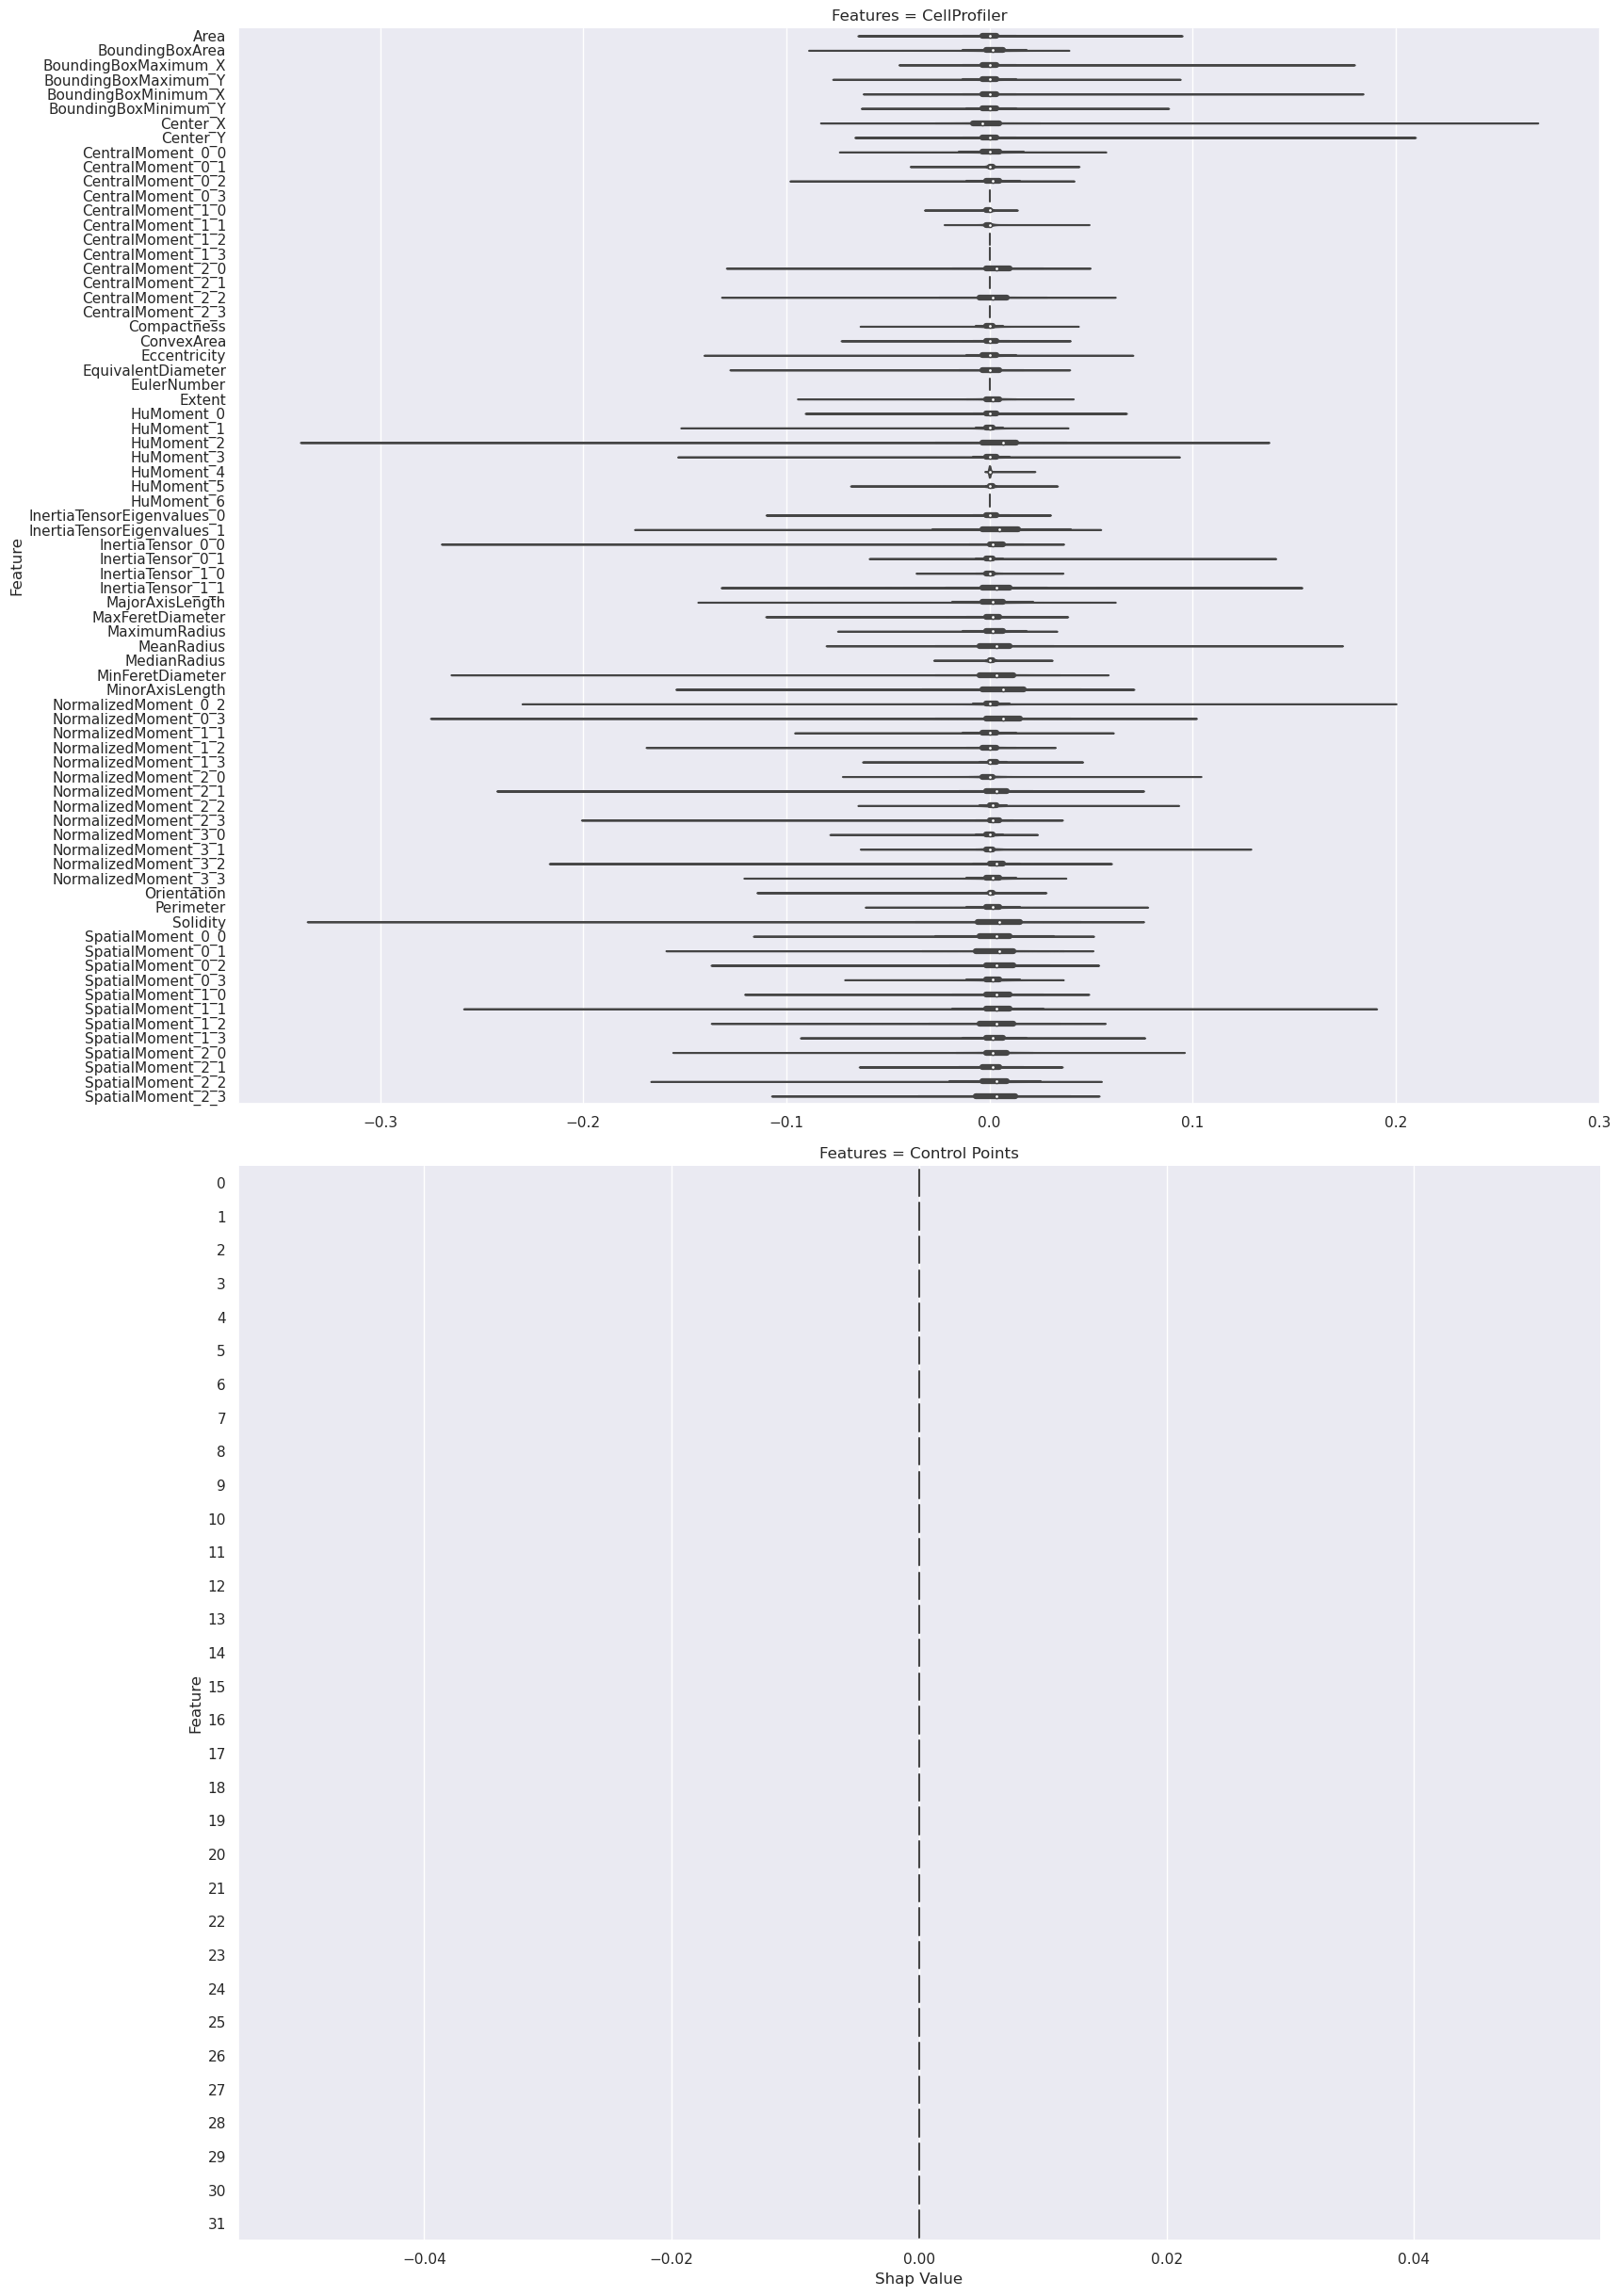

In [12]:

hparams = [
    {
        "df": df_cellprofiler.bip.grouped_median(),
        "name": "CellProfiler",
        "kwargs": {
            "model": Pipeline(
                [
                    ("rf", RandomForestClassifier(n_jobs=-1)),
                ]
            ),
            "algorithm": "auto",  # tree?
        },
    },
    {
        "df": df_splinedist.sample(5),
        "name": "Control Points",
        "kwargs": {
            "model": Pipeline(
                [
                    ("Distogram", shapes.Distogram()),
                    ("scaler", PowerTransformer()),
                    ("rf", RandomForestClassifier(n_jobs=-1)),
                ]
            ),
            "algorithm": "auto",
        },
    },
]


shap_df = pd.concat(
    [
        hparam["df"]
        .bip.get_shap_df(
            **hparam["kwargs"], output_names=list(hparam["df"].columns.astype(str))
        )
        .assign(Features=hparam["name"])
        for hparam in hparams
    ]
)


g = sns.catplot(
    y="Feature",
    x="Shap Value",
    # hue="Feature",
    row="Features",
    kind="violin",
    data=shap_df.pipe(save_csv, "shap.csv"),
    sharex=False,
    sharey=False,
    height=12.27,
    aspect=11.7 / 8.27,
)
plt.savefig(metadata("shap.pdf"))
plt.show()
plt.close()

In [13]:
import os

print("Exporting to notebook")
# os.system(f"jupytext --to notebook splines.py --update --execute")

Exporting to notebook
